In [17]:
import pickle
import os.path
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh import qparser
import random
from nltk.corpus import stopwords
import nltk
import glob
import asr.align
import os
import soundfile as sf
from python_speech_features import mfcc
from python_speech_features import fbank
import lshknn
import numpy as np
import fnmatch
import json
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from numpy import cumsum
import seaborn as sns
import time
from scipy import stats
import statsmodels

In [2]:
audioFileLocation = '/home/ubuntu/DevData-AudioBooks/dev-clean/'
queryAudioLocation = '/home/ubuntu/spokenkeywordsearch/GroundTruth/'
encodingLocation = '/home/ubuntu/model_encoding/'
MFCC = "mfcc"
Encoding = "encoding"

In [3]:
class indexer():
    def __init__(self):
        self.transDict = pickle.load(open('transDict2', 'r'))
        self.convertedDict = pickle.load(open('speechRecConvertDict2', 'r'))
        self.queryList = pickle.load(open('queryList2', 'r'))
        self.queryConvertedDict = pickle.load(open('queryConvertedDict2', 'r'))
        schema = Schema(audio=TEXT(stored=True), content=TEXT)
        if not os.path.exists("index"):
            os.mkdir("index")
        self.index = create_in("index", schema)
        writer = self.index.writer()
        for a in self.transDict:
            writer.add_document(audio=u""+a, content=u""+self.transDict[a])
        writer.commit()
        self.searcher = self.index.searcher()
        
    def getMaxSearch(self):
        maxFoundList = [0]*len(self.queryList)
        diffCount = 0
        for i in range(len(self.queryList)):
            if(self.queryList[i] and self.queryConvertedDict[str(i)]):
                query1 = QueryParser("content", self.index.schema, group=qparser.OrGroup).parse(self.queryList[i])
                result1 = self.searcher.search(query1, limit=None)
                list1 = []
                for res in result1:
                    list1.append(res['audio'])
                maxFoundList[i] = len(list1)
        return maxFoundList
    
    def compareResults(self, indices, distances, audioPosnDict, queryPosnDict, logfileName, limitk, dontPrint=False):
        log = open(logfileName, 'a')
        totalQueryCount = 0
        totalTrueResults = 0
        totalMatchingResults = 0
        maxMatchingQuery = ""
        maxMatching = 0
        maxFoundList = self.getMaxSearch()
        precisionList = []
        recallList = []
        i = 0
        totalFrames = len(distances)
        while(i<totalFrames):
            samePos = []
            while(i+1<totalFrames and queryPosnDict[i]==queryPosnDict[i+1]):
                samePos.append(i)
                i += 1
            if(len(samePos)==0):
                samePos = [i]
            totalQueryCount += 1
            log.write("------------------------------------------------")
            query = self.queryList[int(queryPosnDict[i])]
            log.write("Results for query: " + query +"\n")
            query = QueryParser("content", self.index.schema, group=qparser.OrGroup).parse(query)
            results = self.searcher.search(query, limit=limitk)
            list1 = []
            list2 = []
            for res in results:
                list1.append(res['audio'])
            distanceArr = np.array(distances[samePos[0]:samePos[len(samePos)-1]+1]).flatten()
            indiceArr = np.array(indices[samePos[0]:samePos[len(samePos)-1]+1]).flatten()
            distanceArr = (-distanceArr).argsort()[:min(limitk, len(distanceArr))]
            for d in distanceArr:
                list2.append(audioPosnDict[indiceArr[d]])
            comm = len(set(list1).intersection(set(list2)))
            foundCount = len(list2)
            origCount = maxFoundList[int(queryPosnDict[i])]
            if(foundCount>0):
                precisionList.append(float(comm)/float(foundCount))
            else:
                precisionList.append(0.0)
            if(origCount>0):
                recall = float(comm)/float(min(limitk, origCount))
                if(recall == 1.0 or recall == 1):
                    print("Query with recall 1.0: ", query)
                recallList.append(float(comm)/float(min(limitk, origCount)))
            else:
                recallList.append(0)
            totalTrueResults += len(list1)
            if(comm>maxMatching):
                maxMatching = comm
                maxMatchingQuery = query
            totalMatchingResults += comm
            log.write("Matching : {0}".format(comm))
            log.flush()
            i += 1
        if(not dontPrint):
            print("Total queries: ", totalQueryCount)
            print("Total true finds: ", totalTrueResults)
            print("Total matching results: ", totalMatchingResults)
        return precisionList, recallList

In [82]:
class knn_mfcc():
    def __init__(self, featureType, stride, windowSize):
        self.featureType = featureType
        self.stride = stride
        self.windowSize = windowSize
        self.knnnbrs = []
        
    def initializeFeatures(self, featLocation, kind):
        features = []
        posnDict = dict()
        totalFileCount = 0
        frameCount = 0
            
        if(self.featureType == "mfcc"):
            for root, dirnames, filenames in os.walk(featLocation):
                for filename in fnmatch.filter(filenames, '*.wav'):
                    totalFileCount += 1
                    with open(os.path.join(root, filename), 'rb') as f:
                        data, samplerate = sf.read(f)
                    if(kind=="audio"):
                        mfcc_feat = np.array(mfcc(data, samplerate))
                    else:
                        mfcc_feat = np.array(mfcc(data, samplerate, nfft=600))
                    mfcclen = len(mfcc_feat)
                    i = 0
                    lastLen = 0
                    while(i+self.windowSize<mfcclen):
                        features.append(mfcc_feat[i:i+self.windowSize].flatten())
                        lastLen = len(mfcc_feat[i:i+self.windowSize].flatten())
                        posnDict[frameCount] = filename.split('.')[0]
                        i += self.stride
                        frameCount += 1
        elif(self.featureType == "fbank"):
            for root, dirnames, filenames in os.walk(featLocation):
                for filename in fnmatch.filter(filenames, '*.wav'):
                    totalFileCount += 1
                    with open(os.path.join(root, filename), 'rb') as f:
                        data, samplerate = sf.read(f)
                    if(kind=="audio"):
                        fbank_feat, fbank_energy = fbank(data, samplerate)
                        fbank_feat = np.array(fbank_feat)
                    else:
                        fbank_feat, fbank_energy = fbank(data, samplerate, nfft=600)
                        fbank_feat = np.array(fbank_feat)
                    fbanklen = len(fbank_feat)
                    i = 0
                    lastLen = 0
                    while(i+self.windowSize<fbanklen):
#                         print(fbank_feat[i:i+self.windowSize].flatten()[0])
#                         print(fbank_energy[i:i+self.windowSize])
                        features.append(np.append(fbank_feat[i:i+self.windowSize].flatten(), (fbank_energy[i:i+self.windowSize])))
                        posnDict[frameCount] = filename.split('.')[0]
                        i += self.stride
                        frameCount += 1
                        
        elif(self.featureType == "encoding"):
            if(kind=="audio"):
                fileType = '*.flac.json'
            else:
                fileType = '*.wav.json'
            for root, dirnames, filenames in os.walk(featLocation):
                for filename in fnmatch.filter(filenames, fileType):
                    totalFileCount += 1
                    curr = np.array(json.load(open(root+filename, 'r')))
                    for c in curr:
                        features.append(c)
                        posnDict[frameCount] = filename.split('.')[0]
                        frameCount += 1
        return features, posnDict
    
    def initKNN(self, k, knnalgorithm, audioFeatures, metric=None):
        if(metric is not None):
            self.knnnbrs = NearestNeighbors(n_neighbors=k, algorithm=knnalgorithm, metric=metric).fit(audioFeatures)
        else:
            self.knnnbrs = NearestNeighbors(n_neighbors=k, algorithm=knnalgorithm).fit(audioFeatures)
        
    def searchForQuery(self, queryFeatures):
        return self.knnnbrs.kneighbors(queryFeatures)

In [80]:
def getResults(featureType, stride, windowSize, ks):
    knnObj = knn_mfcc(featureType, stride, windowSize)
    audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
    print(len(audioFeatures))
    queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
    print(len(queryFeatures))
    
    for kt in ks:
        print("----------------"+str(kt)+"-------------------------")
        knnObj.initKNN(kt, "ball_tree", audioFeatures)
        print("Done initKNN")
        startTime = time.time()
        nndistances, nnindices = knnObj.searchForQuery(queryFeatures)
        print("Time taken in query search: ", str(time.time()-startTime))
        print("Done finding nearest neighbors")
        resultchecker = indexer()
        precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', kt)
        print(precisionList)
        print(recallList)
#         pickle.dump
        try:
            sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Precision")
        except ImportError:
            doNothing = 0
        plt.title("CDF of precision @ k="+str(kt))
        plt.show()
        try:
            sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Recall")
        except ImportError:
            doNothing = 0
        plt.title("CDF of recall @ k="+str(kt))
        plt.show()

In [6]:
def getTimeResults(featureType, stride, windowSize, ks):
    knnObj = knn_mfcc(featureType, stride, windowSize)
    audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
    print(len(audioFeatures))
    queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
    print(len(queryFeatures))
    mainTimeList = []
    for kt in ks:
        print("----------------"+str(kt)+"-------------------------")
        knnObj.initKNN(kt, "ball_tree", audioFeatures)
        print("Done initKNN")
        timeList = []
        i = 0
        totalQueryFrames = len(queryFeatures)
        resultchecker = indexer()
        while(i<totalQueryFrames):
            samePos = []
            while(i+1<totalQueryFrames and queryPosnDict[i]==queryPosnDict[i+1]):
                samePos.append(i)
                i += 1
            if(len(samePos)==0):
                samePos = [i]
            
            startTime = time.time()
            nndistances, nnindices = knnObj.searchForQuery(queryFeatures[samePos[0]:samePos[len(samePos)-1]+1])
            timeTaken = time.time() - startTime
            if(len(timeList)%500==0):
                print("Done finding nearest neighbors")
                print("Time taken in query search: ", str(timeTaken))
            timeList.append(timeTaken)
            precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', kt, True)
            
            i += 1
        try:
            sns.distplot(timeList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Time in seconds")
        except ImportError:
            doNothing = 0
        plt.title("CDF of time @ k="+str(kt))
        plt.show()
        
        mainTimeList.append(timeList)
        return mainTimeList

186858
18802
----------------10-------------------------
Done initKNN
Done finding nearest neighbors
('Time taken in query search: ', '0.954905986786')
Done finding nearest neighbors
('Time taken in query search: ', '0.680065155029')
Done finding nearest neighbors
('Time taken in query search: ', '1.11602401733')
Done finding nearest neighbors
('Time taken in query search: ', '0.69078207016')
Done finding nearest neighbors
('Time taken in query search: ', '0.414313077927')
Done finding nearest neighbors
('Time taken in query search: ', '0.693244934082')


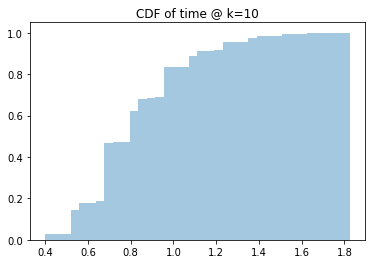

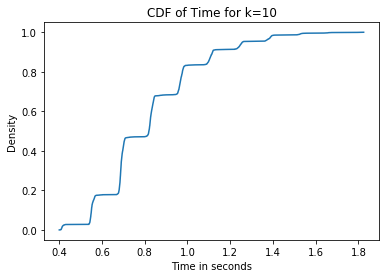

In [50]:
mainTimeList = getTimeResults(MFCC, 10, 30, [10])
sorted_data = np.sort(np.array(mainTimeList[0]))
plt.plot(sorted_data, np.linspace(0,1,len(sorted_data)))
plt.xlabel("Time in seconds")
plt.ylabel("Density")
plt.title("CDF of Time for k=10")
plt.show()

186858
18802
----------------10-------------------------
Done initKNN
Done finding nearest neighbors
('Time taken in query search: ', '0.961097955704')
Done finding nearest neighbors
('Time taken in query search: ', '0.690325975418')
Done finding nearest neighbors
('Time taken in query search: ', '1.14575409889')
Done finding nearest neighbors
('Time taken in query search: ', '0.683841943741')
Done finding nearest neighbors
('Time taken in query search: ', '0.41261100769')
Done finding nearest neighbors
('Time taken in query search: ', '0.698448896408')


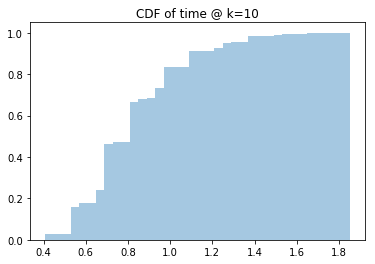

In [8]:
mainTimeList = getTimeResults(MFCC, 10, 30, [10])

186858
18802
----------------50-------------------------
Done initKNN
Done finding nearest neighbors
('Time taken in query search: ', '0.959035158157')
Done finding nearest neighbors
('Time taken in query search: ', '0.686432123184')
Done finding nearest neighbors
('Time taken in query search: ', '1.09921884537')
Done finding nearest neighbors
('Time taken in query search: ', '0.675734996796')
Done finding nearest neighbors
('Time taken in query search: ', '0.411838054657')
Done finding nearest neighbors
('Time taken in query search: ', '0.672003984451')


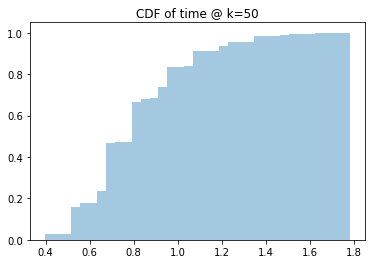

In [7]:
mainTimeList = getTimeResults(MFCC, 10, 30, [50])

In [10]:
#Average time for a query in k=50 using mfcc
print(np.mean(np.array(mainTimeList[0])))
#Total time for a query in k=50
print(np.sum(np.array(mainTimeList[0])))

0.8132673756440304
2198.261716365814


In [39]:
try:
    import statsmodels.nonparametric.api as smnp
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False
print(_has_statsmodels)

True


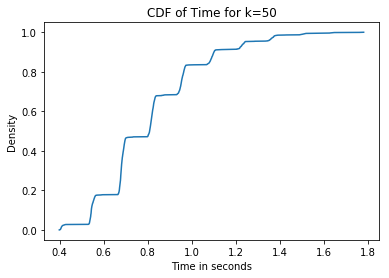

In [49]:
# import statsmodels.api as smnp
# sns.distplot(mainTimeList[0], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Time in seconds")
# try:
#     sns.kdeplot(mainTimeList[0], cumulative=True)
# except:
#     nonsense = 0
sorted_data = np.sort(np.array(mainTimeList[0]))
plt.plot(sorted_data, np.linspace(0,1,len(sorted_data)))
plt.xlabel("Time in seconds")
plt.ylabel("Density")
plt.title("CDF of Time for k=50")
plt.show()

186858
18802
----------------50-------------------------
Done initKNN
('Time taken in query search: ', '2585.18379307')
Done finding nearest neighbors
<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f56ec03ff60>
('Query with recall 1.0: ', Term('content', u'physicians'))
('Query with recall 1.0: ', Term('content', u'survives'))
('Query with recall 1.0: ', Term('content', u'sideways'))
('Query with recall 1.0: ', Term('content', u'robert'))
('Query with recall 1.0: ', Term('content', u'survives'))
('Query with recall 1.0: ', Term('content', u'defied'))
('Query with recall 1.0: ', Term('content', u'superfluous'))
('Query with recall 1.0: ', Term('content', u'cart'))
('Query with recall 1.0: ', Term('content', u'superfluous'))
('Query with recall 1.0: ', Term('content', u'reasoning'))
('Query with recall 1.0: ', Term('content', u'blasphemous'))
('Query with recall 1.0: ', Term('content', u'robert'))
('Query with recall 1.0: ', Term('content', u'terminating'))
('Query with recall 1.0: ', T

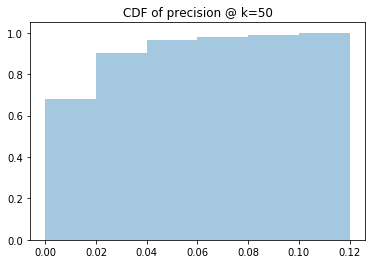

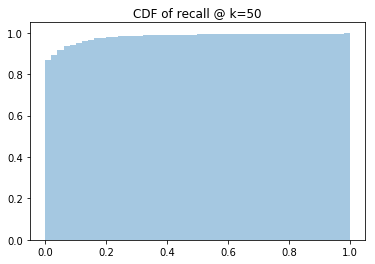

----------------10-------------------------
Done initKNN
('Time taken in query search: ', '2534.67115188')
Done finding nearest neighbors
<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f5713388db0>
('Query with recall 1.0: ', Term('content', u'entreated'))
('Query with recall 1.0: ', Term('content', u'robert'))
('Query with recall 1.0: ', Term('content', u'entreated'))
('Query with recall 1.0: ', Term('content', u'numeral'))
('Query with recall 1.0: ', Term('content', u'reasoning'))
('Query with recall 1.0: ', Term('content', u'robert'))
('Query with recall 1.0: ', Term('content', u'whilst'))
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 177)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0

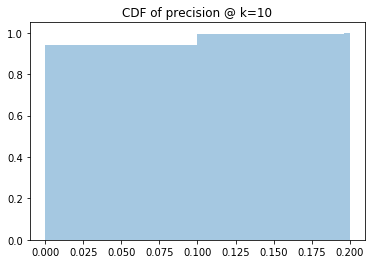

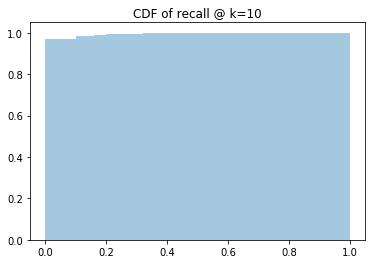

In [6]:
getResults(MFCC, 10, 30, [50, 10])

186858
18802
----------------10-------------------------
Done initKNN
Done finding nearest neighbors
<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f65e4d21390>
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 177)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

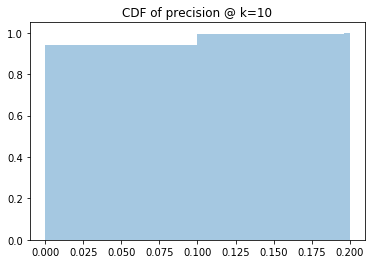

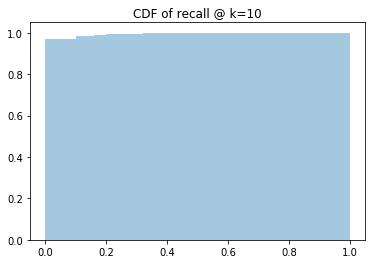

----------------50-------------------------
Done initKNN


In [ ]:
getResults(MFCC, 10, 30, [10, 50])

In [23]:
# Using MFCC Features
knnObj = knn_mfcc("mfcc", 10, 30)
audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
print(len(audioFeatures))
# print(len(audioPosnDict))
queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
print(len(queryFeatures))
# print(len(queryPosnDict))

186858
18802


In [22]:
knnObj.initKNN(10, "brute", audioFeatures, 'cosine')
print("Done initKNN")
startTime = time.time()
nndistances, nnindices = knnObj.searchForQuery(queryFeatures[:1])
print("Done finding nearest neighbors in time: ", str(time.time()-startTime))
resultchecker = indexer()
precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', 10)

Done initKNN
('Done finding nearest neighbors in time: ', '1.41303300858')
('Total queries: ', 1)
('Total true finds: ', 1)
('Total matching results: ', 0)


In [79]:
resultchecker = indexer()
precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', 10)

<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f024071eed0>
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 649)


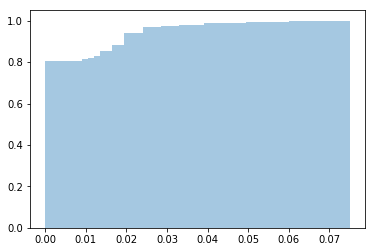

In [80]:
try:
    sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

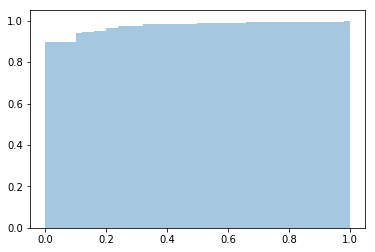

In [81]:
try:
    sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

In [6]:
# Using Encoding features
knnEncObj = knn_mfcc("encoding", 10, 30)
audioEncFeatures, audioEncPosnDict = knnEncObj.initializeFeatures(encodingLocation, "audio")
print(len(audioFeatures))
# print(len(audioPosnDict))
queryEncFeatures, queryEncPosnDict = knnEncObj.initializeFeatures(encodingLocation, "query")
print(len(queryFeatures))
# print(len(queryPosnDict))

190833
190833
2703
2703


In [50]:
# Using Encoding features
# k = 10
# knnEncObj.initKNN(k, "ball_tree", audioEncFeatures)
# print("Done initKNN")
# nnEncDistances, nnEncIndices = knnEncObj.searchForQuery(queryEncFeatures)
# print(len(nndistances))
# print("Done finding nearest neighbors")
resultchecker = indexer()
precisionList, recallList = resultchecker.compareResults(nnEncIndices, nnEncDistances, audioEncPosnDict, queryEncPosnDict, 'mfccFeaturek10.txt', k)

<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f023f945420>
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 84)


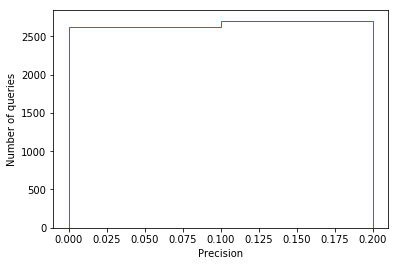

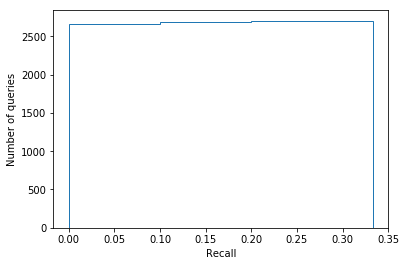

In [70]:
plt.hist(precisionList, cumulative=True, histtype='step')
plt.xlabel("Precision")
plt.ylabel("Number of queries")
plt.show()

plt.hist(recallList, cumulative=True, histtype='step')
plt.xlabel("Recall")
plt.ylabel("Number of queries")
plt.show()

In [56]:
print(precisionCDF)

[0.  0.  0.  ... 8.4 8.4 8.4]


In [51]:
print(precisionList)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

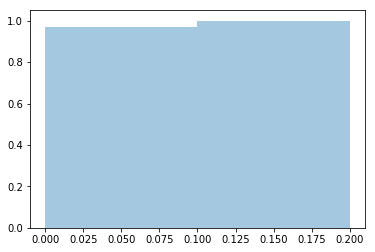

In [73]:
try:
    sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

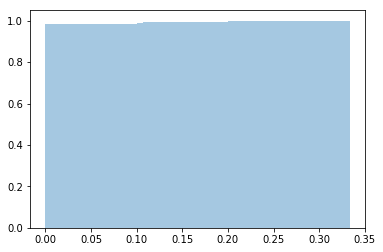

In [75]:
try:
    sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

In [62]:
for root, dirnames, filenames in os.walk('/home/ubuntu/DevData-AudioBooks/dev-clean/'):
    for filename in fnmatch.filter(filenames, '*.wav'):
#         totalFileCount += 1
        with open(os.path.join(root, filename), 'rb') as f:
            data, samplerate = sf.read(f)
#         if(kind=="audio"):
        a, b = fbank(data, samplerate, winlen=0.2, winstep=0.1, nfft=3200)
        print(len(a[0]))
        print("-----------")
        print(len(b))
        mfcc_feat = np.array(fbank(data, samplerate))
        print(mfcc_feat.shape)

26
-----------
241


ValueError: could not broadcast input array from shape (2411,26) into shape (2411)

In [83]:
knnObj = knn_mfcc("fbank", 10, 30)
audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
print(len(audioFeatures))
# print(len(audioPosnDict))
queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
print(len(queryFeatures))

186858
18802


In [84]:
kt = 10
knnObj.initKNN(kt, "ball_tree", audioFeatures)
print("Done initKNN")
startTime = time.time()
nndistances, nnindices = knnObj.searchForQuery(queryFeatures)
print("Time taken in query search: ", str(time.time()-startTime))
print("Done finding nearest neighbors")
resultchecker = indexer()
precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', kt)

Done initKNN
('Time taken in query search: ', '3592.00605989')
Done finding nearest neighbors
('Query with recall 1.0: ', Term('content', u'invading'))
('Query with recall 1.0: ', Term('content', u'enclosure'))
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 66)
